In [19]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import pip
import altair as alt
# pip.main(["install", "openpyxl"])
%matplotlib inline

In [5]:
df_log2298 = pd.read_excel(r'~/SCALOS/data/runlogs/Autosort Run Log 2298.xlsx')
df_log2320 = pd.read_excel(r'~/SCALOS/data/runlogs/Autosort Run Log 2320.xlsx')
df_log2326 = pd.read_excel(r'~/SCALOS/data/runlogs/Autosort Run Log 2326.xlsx')
df_log2331 = pd.read_excel(r'~/SCALOS/data/runlogs/Autosort Run Log 2331.xlsx')
df_data2298 = pd.read_csv(r'~/SCALOS/data/finaldata_uw2298.csv')
df_data2320 = pd.read_csv(r'~/SCALOS/data/finaldata_uw2320.csv')
df_data2326 = pd.read_csv(r'~/SCALOS/data/finaldata_uw2326.csv')
df_data2331 = pd.read_csv(r'~/SCALOS/data/finaldata_uw2331.csv')

In [7]:
class DataProcess:

    def data_extract(df_log, df_data, test, runnum):
        # Unit test
        if type(test) != type(runnum):
            raise ValueError("Test entries and run numbers must be consistent!")

        df_data_sub = pd.DataFrame()
        df_log_sub = pd.DataFrame()
        # Unit test
        for i in range(len(test)):
            # Test Entries must be integer
            if not isinstance(test[i], int):
                raise ValueError("Test entries must be integer!")

            # Entries must be not empty
            if not np.any(test[i]) or not np.any(runnum[i]):
                raise ValueError("Test entries and run numbers must be not empty!")

            # Test entries must be valid
            if not any(np.unique(df_log[df_log.columns.tolist()[1]]) == test[i]):
                raise ValueError("Test entries are invalid!")

            # Run number must be a list
            if not isinstance(runnum[i], list):
                raise ValueError("Run numbers are invalid!")

    #         len_i = len()
            for j in range(len(runnum[i])):
                # Each run number must be valid
                if runnum[i][j] < 0 or runnum[i][j] > np.max(
                        df_log[df_log.columns.tolist()[0]][df_log[df_log.columns.tolist()[1]] == test[i]]):
                    raise ValueError("Run numbers are invalid!")

            # Entries must be not weight tare
    #         for j in range(len_i):
                if np.any(pd.isna(df_log[df_log.columns.tolist()[2]][(df_log[df_log.columns.tolist()[1]] == test[i]) & (
                        df_log[df_log.columns.tolist()[0]] == runnum[i][j])])):
                    raise ValueError("Test num and corresponding run num is weight tare")

    #         for j in range(len_i):
                df_log_sub = pd.concat([df_log_sub, df_log[
                    (df_log[df_log.columns.tolist()[1]] == test[i]) & (df_log[df_log.columns.tolist()[0]] == runnum[i][j])]],
                                       ignore_index=True, axis=0)
                df_data_sub = pd.concat([df_data_sub, df_data[
                    (df_data[df_data.columns.tolist()[1]] == test[i]) & (df_data[df_data.columns.tolist()[0]] == runnum[i][j])]],
                                        ignore_index=True, axis=0)

            # Run type must be consistant
        if len(pd.unique(df_log_sub[df_log.columns.tolist()[4]])) > 1:
            raise ValueError("Run type is inconsistant!")
        df_log_sub["RUN NO."] = df_log_sub["RUN NO."].astype(int)

        df_data_sub[["RUN","TEST"]] = df_data_sub[["RUN","TEST"]].astype(int)
        
        return df_log_sub, df_data_sub

    def data_interp_derivative(df_log_sub, df_data_sub, test, runnum):
        
        if pd.unique(df_log_sub[df_log.columns.tolist()[4]]) == 'P6':
            alphabeta = df_data_sub.columns.tolist()[3]
        elif pd.unique(df_log_sub[df_log.columns.tolist()[4]]) == 'Y6':
            alphabeta = df_data_sub.columns.tolist()[4]
        else:
            raise ValueError("Run type error!")

        max_list =[]
        min_list =[]

        for i in range(len(test)):
            for j in range(len(runnum[i])):
                max_list.append(np.max(df_data_sub[alphabeta][(df_data_sub[df_data_sub.columns.tolist()[1]] == test[i]) & (df_data_sub[df_data_sub.columns.tolist()[0]] == runnum[i][j])]))
                min_list.append(np.min(df_data_sub[alphabeta][(df_data_sub[df_data_sub.columns.tolist()[1]] == test[i]) & (df_data_sub[df_data_sub.columns.tolist()[0]] == runnum[i][j])]))

        alphabeta_interp= np.arange(np.ceil(np.max(min_list)), np.floor(np.min(max_list))+1, 1)

        if np.min(alphabeta_interp) != np.ceil(np.max(min_list)) or np.max(alphabeta_interp) != np.floor(np.min(max_list)):
            raise ValueError("Data range incorrect")

        df_data_sub_interp = pd.DataFrame()
        df_data_sub_derivative = pd.DataFrame()
        
        for i in range(len(test)):
            temp_interp = pd.DataFrame()
            temp_derivative = pd.DataFrame()
            for k in range(len(runnum[i])):
                for j in range(len(df_data_sub.columns.tolist())):
                    if j <= 8:
                        if df_data_sub.columns.tolist()[j] == alphabeta: 
                            temp_interp[df_data_sub.columns.tolist()[j]] = alphabeta_interp
                            temp_derivative[df_data_sub.columns.tolist()[j]] = alphabeta_interp
                        else:
                            temp_fun = sp.interpolate.interp1d(
                                        df_data_sub[alphabeta][(df_data_sub[df_data_sub.columns.tolist()[1]] == test[i]) & (df_data_sub[df_data_sub.columns.tolist()[0]] == runnum[i][k])],
                                        df_data_sub[df_data_sub.columns.tolist()[j]][(df_data_sub[df_data_sub.columns.tolist()[1]] == test[i]) & (df_data_sub[df_data_sub.columns.tolist()[0]] == runnum[i][k])],
                                        kind = 'nearest')
                            temp_interp[df_data_sub.columns.tolist()[j]] = temp_fun(alphabeta_interp)
                            temp_derivative[df_data_sub.columns.tolist()[j]] = temp_fun(alphabeta_interp)
                    else:
                        temp_fun = sp.interpolate.interp1d(
                                    df_data_sub[alphabeta][(df_data_sub[df_data_sub.columns.tolist()[1]] == test[i]) & (df_data_sub[df_data_sub.columns.tolist()[0]] == runnum[i][k])],
                                    df_data_sub[df_data_sub.columns.tolist()[j]][(df_data_sub[df_data_sub.columns.tolist()[1]] == test[i]) & (df_data_sub[df_data_sub.columns.tolist()[0]] == runnum[i][k])],
                                    kind = 'linear')
                        temp_interp[df_data_sub.columns.tolist()[j]] = temp_fun(alphabeta_interp)
                        temp_derivative[df_data_sub.columns.tolist()[j]] = np.gradient(temp_fun(alphabeta_interp), alphabeta_interp)


                df_data_sub_interp = pd.concat([df_data_sub_interp, temp_interp], ignore_index = True, axis = 0) 
                df_data_sub_derivative = pd.concat([df_data_sub_derivative, temp_derivative], ignore_index = True, axis = 0) 
                
        return df_data_sub_interp, df_data_sub_derivative 

In [8]:
class DataPlot:
    
    def plt_data(plot_vars, df_log_sub, df_data_sub, test, runnum):
        if pd.unique(df_log_sub[df_log.columns.tolist()[4]]) == 'P6':
            alphabeta = df_data_sub.columns.tolist()[3]
            x_label = "\\alpha"
        elif pd.unique(df_log_sub[df_log.columns.tolist()[4]]) == 'Y6':
            alphabeta = df_data_sub.columns.tolist()[4]
            x_label = "\\beta"
        else:
            raise ValueError("Run type error!")

        for j in range(len(plot_vars)):
            plt.figure()
            for i in range(len(test)):
                for k in range(len(runnum[i])):
                    plt.scatter(df_data_sub[alphabeta][(df_data_sub[df_data_sub.columns.tolist()[1]] == test[i]) & (df_data_sub[df_data_sub.columns.tolist()[0]] == runnum[i][k])],
                         df_data_sub[plot_vars[j]][(df_data_sub[df_data_sub.columns.tolist()[1]] == test[i]) & (df_data_sub[df_data_sub.columns.tolist()[0]] == runnum[i][k])], 
                         label='UW'+str(test[i])+' Run'+str(runnum[i][k]))
            plt.xlabel(r"$"+x_label+" (^\circ)$")
            if plot_vars[j] == "LOD":
                y_label = "C_L/C_D"
            else:
                y_label = plot_vars[j][0]+"_"+plot_vars[j][1]+"("+plot_vars[j][2:]+") "
            plt.ylabel(r"$"+y_label+ "$")
            if j == 0:
                plt.legend()
            plt.title(r"$"+y_label + " vs. "+ x_label+"$")
            plt.grid(True)
            plt.show()


In [9]:
df_log, df_log2298, df_log2320, df_log2326, df_log2331 = DataPrep.runlog_cleanup(df_log2298, df_log2320, df_log2326, df_log2331 )
df_data = DataPrep.data_cleanup(df_data2298, df_data2320, df_data2326, df_data2331)

In [10]:
test = [2320, 2320, 2298, 2298, 2298]
runnum = [[49, 50, 51, 52], 
          [116, 119, 120, 121, 122], 
          [37,], 
          [87, 88], 
          [47, 48, 49, 51]]

test = [2298]
runnum = [[49, 51, 37, 56, 57, 26]]
df_log_sub, df_data_sub = DataProcess.data_extract(df_log, df_data, test, runnum)

In [11]:
df = df_data_sub
df['RUN'] = df['RUN'].astype(str)
chart  = alt.Chart(df).mark_line().encode(
    x=alt.X('ALPHAC', axis=alt.Axis(title='alpha')),
    y=alt.Y('CDSA', axis=alt.Axis(title='CL')),
    color = alt.Color('RUN:N'))
# chart.configure_legend(
#     strokeColor='gray',
#     fillColor='#EEEEEE',
#     padding=10,
#     cornerRadius=10,
#     # orient='top-right'
# )
#chart.save('chart1.html')
chart.display()

alt.Chart(...)

In [12]:
df = df_data_sub
df['RUN'] = df['RUN'].astype(str)

base = alt.Chart().mark_trail().encode(
    color='RUN:N',
    x=alt.X('ALPHAC', axis=alt.Axis(title='alpha'))
).properties(
    width=400,
    height=300
).interactive()
chart = alt.vconcat(data=df)
for y_encoding in ["CLSA", "CDSA", "CYSA", "CMSA25", "CNSA25", "CRSA25", "LOD"]:
    row = alt.hconcat()
    # for x_encoding in ['ALPHAC']:
    row |= base.encode( y=y_encoding)
    chart &= row
    # chart |= base.transform_filter(df.y_encoding == y_encoding )

chart

# chart  = alt.Chart(df).mark_line().encode(
#     x=alt.X('ALPHAC', axis=alt.Axis(title='alpha')),
#     y=alt.Y('CDSA', axis=alt.Axis(title='CL')),
#     color = alt.Color('RUN:N')).interactive()


# chart.save('chart_run2298.html')
chart.display()

alt.VConcatChart(...)

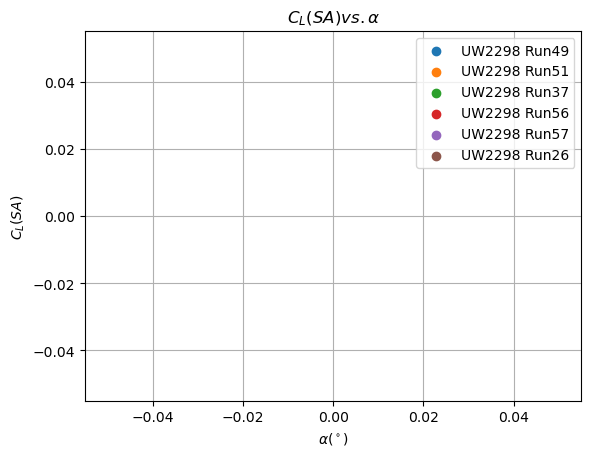

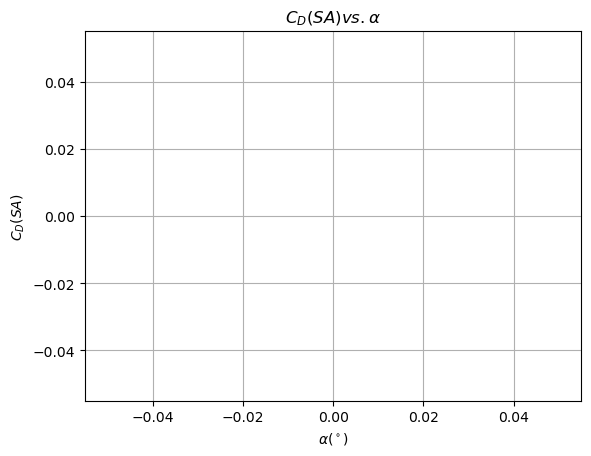

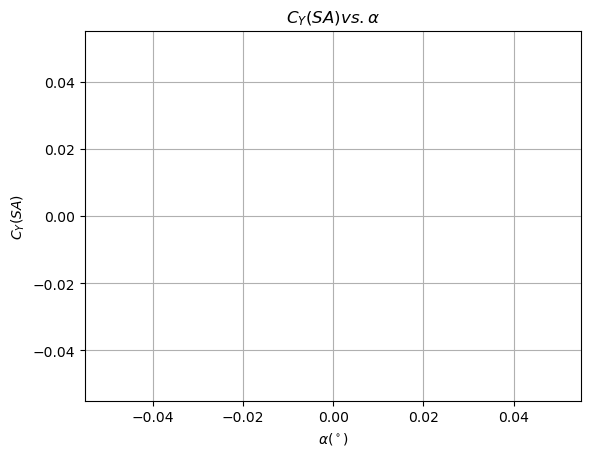

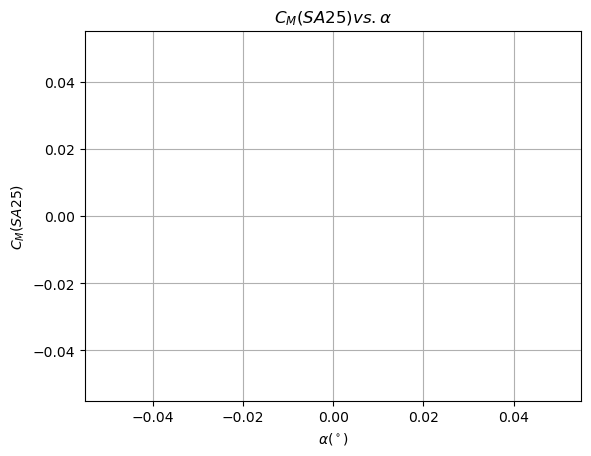

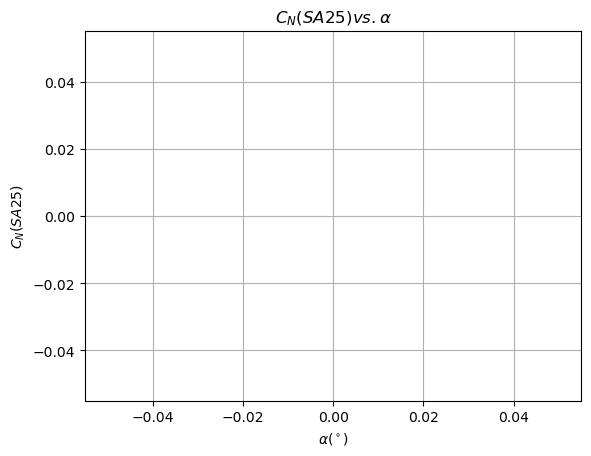

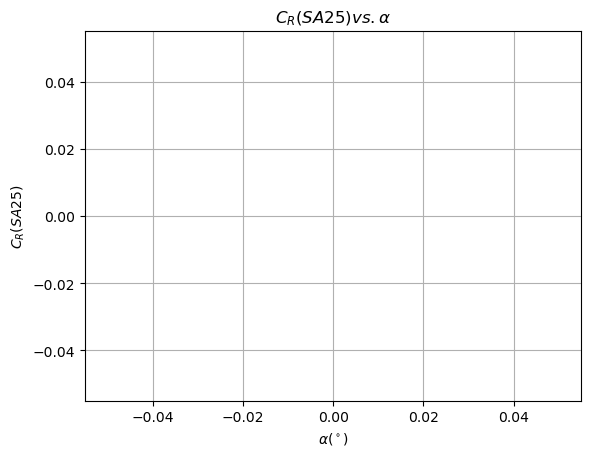

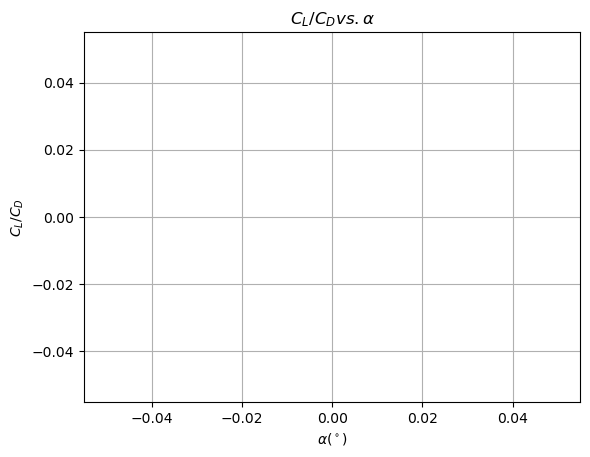

In [13]:
plot_vars = ["CLSA", "CDSA", "CYSA", "CMSA25", "CNSA25", "CRSA25", "LOD"]
DataPlot.plt_data(plot_vars, df_log_sub, df_data_sub, test, runnum)

In [14]:
df_data_sub_interp, df_data_sub_derivative = DataProcess.data_interp_derivative(df_log_sub, df_data_sub, test, runnum)
DataPlot.plt_data(plot_vars, df_log_sub, df_data_sub_derivative, test, runnum)

ValueError: arange: cannot compute length